# Speech-to-text model by Khumoyun Abdulpattoev

**CS387 Spring 2024**

# Introduction

The main goal was to create and train a speech-to-text model.  As we have learned about different model architectures and their pros and cons, I wanted to explore what processes make speech recognition possible. Although it is a huge area of expertise in general, I wanted to explore foundational concepts and processes at the very least and create a model of my own that could transcribe the audio. Initially, it was a very interesting proposal that made me think about its potential applications and improvements I could make upon it, but as I went on with the project, I realized that it was extremely challenging given the sheer variety of concepts that I had to learn to undestand it all.

I split up my work based on a six-week plan:

Week 1 - Research the process and concepts

Week 2 - Data Collection and Feature Extraction

Week 3-5 - Model Development and Training

Week 6 - Enhancement and evaluation

My plan was to do enough research to understand how to make an STT model first. Then, I planned to put all the gained knowledge into practice and create the model. Finally, I wanted to have some time to fine tune the model, so it shows the most optimal perfomance given its architecture.


**A little about the structure of the notebook**

I did my best to structure the report in a way that makes it easier to understand what is going on. I decided to have snippets of explanation and background information alongside the code they are related to. I think this structure works better as the concepts and code discussed are  Analysis of the project and its results as well as the conclusion are going to have their own bigger sections without any code.


# Important Terms and Concepts

**Spectogram** is a visual representation of the different frequencies present in a sound as they vary with time. It is essentially a graph with time on the horizontal axis, frequency on the vertical axis, and colors indicating the strength or loudness of each frequency at each point in time


**Fourier Transform** is a mathematical technique used to transform a signal from its original domain (often time or space) into a representation in the frequency domain. In simpler terms, it breaks down a waveform (like an audio signal) into its constituent frequencies, helping to identify the different tones (low, medium, high) that make up the overall sound

**Mel-Frequency Cepstral Coefficients (MFCC)** are derived from the cepstral representation of audio, which is a measure of how the spectral properties (frequency-related properties) of a sound change over time. MFCCs specifically focus on the frequencies that are important to human hearing (emphasizing lower frequencies more than higher ones, similar to how our ears perceive sound), making them very effective for recognizing spoken words.


**Filter Bank energy** refers to the amplitudes of frequencies measured over several ranges or bands. It is a collection of band-pass filters that divides the input audio signal into multiple components, each one carrying a single frequency sub-band of the original signal.

Lastly, it is important to understand how a computer processes sounds. It is explained in general and in greated detail in the following sections.

Source for some of the concepts: https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html?undefined=&ref=assemblyai.com

# Imports

We are going to need quite a few of libraries to make our model work. Main ones are torch and torchaudio; import torch.utils.data as data is used to create dataloaders; torcheval is used to calculate Word Error Rate, a primary accuracy indicator I have chosen

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
import torch.nn.functional as F
import torch.utils.data as data
!pip install torcheval
from torcheval.metrics import WordErrorRate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 4.8 MB/s eta 0:00:00


# Dataset Downloads
I am going to be using LibriSpeech datasets (https://www.openslr.org/12) for training and testing my model. LibriSpeech is a corpus of approximately 1000 hours of 16kHz read English speech, prepared by Vassil Panayotov with the assistance of Daniel Povey. The data is derived from read audiobooks from the LibriVox project. Luckily, it is built-in to torchaudio library, so downloading the datasets poses no challenges. My model was trained on 100 hours of audio, but LibriSpeech does provide more data that could be helpful in enhancing the model further.

In [ ]:
# Download the datasets
train_dataset = torchaudio.datasets.LIBRISPEECH("./", url="train-clean-100", download=True)
test_dataset = torchaudio.datasets.LIBRISPEECH("./", url="test-clean", download=True)

100%|██████████| 5.95G/5.95G [05:45<00:00, 18.5MB/s]
100%|██████████| 331M/331M [00:22<00:00, 15.7MB/s]


# Text Processing

In order for the following part of the report to make more sense, we need to understand how computers actually process audio. Computers don't "hear" audio the way humans do. Instead, they interpret audio data as a series of numerical values that represent sound waves. I will provide a brief and oversimplified steps involved in that process and explain them in detail in later parts of the report. Audio data is first converted into a spectrogram through the Fourier Transform, which segments the audio and maps out its frequency spectrum over time. This spectrogram is then adjusted to the Mel scale, creating a Mel-spectrogram that emphasizes frequencies crucial for human speech perception. Then, this Mel-spectrogram is fed into a deep learning model, which recognizes patterns corresponding to specific words or phrases based on its training.

I have adapted text procesing part from Nguyen's article referenced earlier. Essentially, TextTransform class maps characters to integers and vice versa. This is particularly useful given that textual data must be converted into a numerical format that can be processed by my model, and the predictions of the model (in numeric form) need to be converted back to human-readable text. Character map includes 26 English alphabet letter, an apostrophe for posessives in the text, space and blank characters.

Feature Extraction and Data Processing is adapted from Michael Nguyen at AssemlyAI(https://www.assemblyai.com/blog/end-to-end-speech-recognition-pytorch/)

In [ ]:
# Character map
char_map_str = """
 ' 0
 <SPACE> 1
 a 2
 b 3
 c 4
 d 5
 e 6
 f 7
 g 8
 h 9
 i 10
 j 11
 k 12
 l 13
 m 14
 n 15
 o 16
 p 17
 q 18
 r 19
 s 20
 t 21
 u 22
 v 23
 w 24
 x 25
 y 26
 z 27
 <BLANK> 28
"""
# added <BLANK>

class TextTransform:
    """Maps characters to integers and vice versa"""
    def __init__(self):
        self.char_map = {}
        self.index_map = {}
        for line in char_map_str.strip().split('\n'):
            ch, index = line.split()
            self.char_map[ch] = int(index)
            self.index_map[int(index)] = ch
        self.index_map[1] = ' '

    def text_to_int(self, text):
        """Converts text to an integer sequence"""
        return [self.char_map[c] if c in self.char_map else self.char_map['<SPACE>'] for c in text]

    def int_to_text(self, labels):
        """Converts integer labels to a text sequence"""
        return ''.join(self.index_map[i] for i in labels).replace('<SPACE>', ' ')

text_transform = TextTransform()

# Data Pipeline

Here goes the part where we dive deeper into how audio/sound is processes by computers. I will describe the process based on what I learned from Haytham Fayek's amazing blog on Speech Processing for Machine Learning. The first step involves using a pre-emphasis filter to amplify high frequencies, which helps balance the frequency spectrum and improves the signal-to-noise ratio. The audio is then divided into overlapping frames to allow precise frequency analysis. Each frame is subjected to a window function, such as the Hamming window, to reduce edge discontinuities and spectral leakage. A Fourier Transform is then applied to convert these windowed frames from the time domain to the frequency domain, and the power spectrum of each frame is calculated to represent the power at each frequency component. Following this, the power spectra are filtered through a Mel-scale filter bank, aligning with human auditory perception by emphasizing relevant speech frequencies. Finally, to create Mel-Frequency Cepstral Coefficients (MFCCs), a Discrete Cosine Transform (DCT) is performed on these Mel-scaled filter banks to decorrelate and compress the frequency bands, selecting only key coefficients that effectively capture and represent the characteristics of the original speech signal for further machine learning applications.

The following images show what waveforms, spectograms, and mel-spectograms look like:

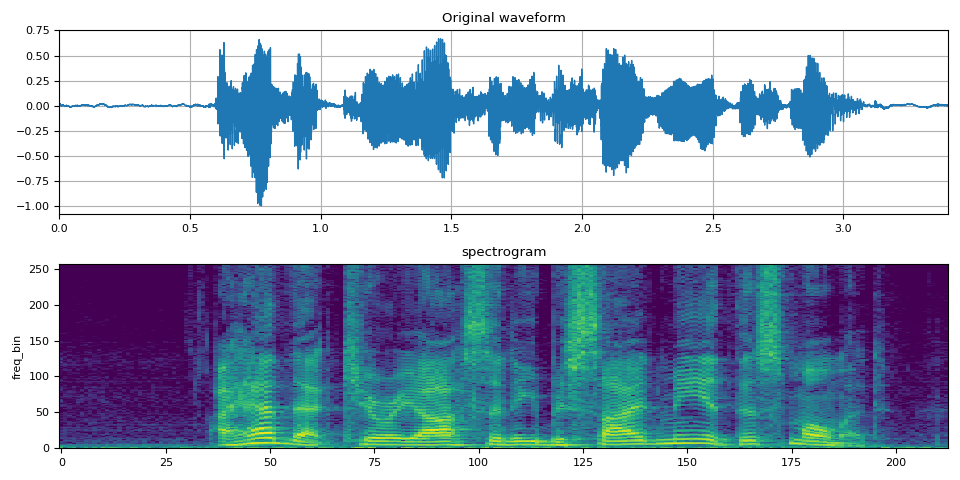

The image shows wave forms and spectograms of "I have that curiosity beside me at this moment"

 Source: https://pytorch.org/audio/stable/tutorials/audio_feature_extractions_tutorial.html#sphx-glr-tutorials-audio-feature-extractions-tutorial-py

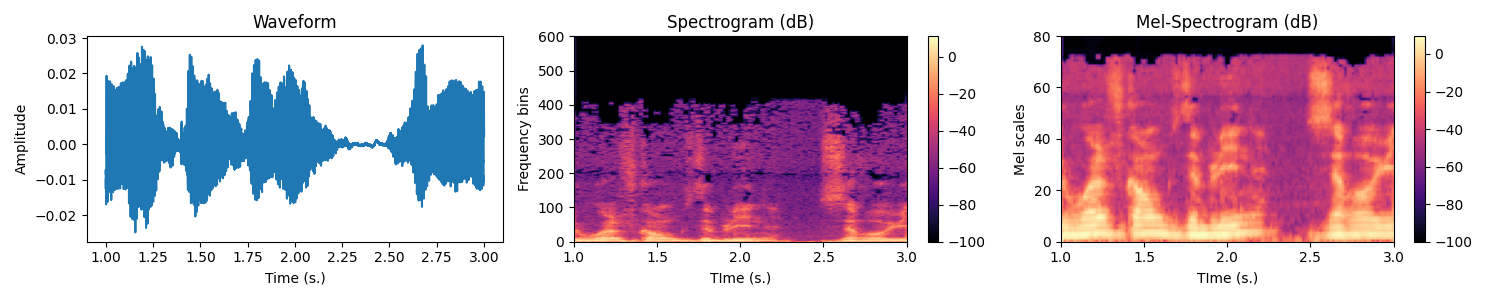 Source: https://teaching.pages.centralesupelec.fr/deeplearning-lectures-build/02-pytorch-asr.html

The folllowing code sets up a pipeline of audio processing steps to prepare raw audio data for training the model. It transforms the audio into a Mel Spectrogram to capture its time-frequency characteristics in a way that mimics human hearing, and applying random masking in both frequency and time dimensions to augment the data. These transformations help the model learn to handle variations and missing information in audio signals, making it more robust and improving its ability to generalize from training data to real-world scenarios.

In [ ]:
# Define audio transformation
train_audio_transforms = nn.Sequential(
    torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=128),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
    torchaudio.transforms.TimeMasking(time_mask_param=35)
)

valid_audio_transforms = torchaudio.transforms.MelSpectrogram()

/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


We have come to one of the most important parts of the project - data processing. This method takes the data and transforms it into numerical sequences (instead of sound waves or letters) that the network can understand and process. It returns spectograms, labels, and lengths of inputs and labels that will be used by the model to learn from the data

In [ ]:
def data_processing(data, data_type="train"):
    """
    Adapted from Nguyen's code, but some changed were made to make sure it works with my model.
    Takes raw data and transforms it into a suitable format. It converts waveforms into spectrograms, and
    transcribes utterances into integer sequences (tensors)
    """
    spectrograms = []
    labels = []
    input_lengths = []
    label_lengths = []
    for (waveform, _, utterance, _, _, _) in data:
        # apply  audio transformations based on the data type
        spec = train_audio_transforms(waveform) if data_type == 'train' else valid_audio_transforms(waveform)
        # Adjust shape for model compatibility. Expected [time, features]
        spec = spec.squeeze(0).transpose(0, 1)
        # convert text to integer labels
        label = torch.Tensor(text_transform.text_to_int(utterance.lower())).int()

        spectrograms.append(spec)
        labels.append(label)
        input_lengths.append(spec.shape[0])
        label_lengths.append(len(label))

    # pad sequences for batch processing
    spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True)
    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True)

    return spectrograms, labels, input_lengths, label_lengths

# Model

This is the model I have created. Initially, it was a GRU only model. I have chosen a GRU model because it is inherently good with sequential data, which sound/audio is. As we have learnt in class, GRU can handle long-term dependencies in sequential data by selectively remembering and forgetting previous inputs, making it a great option for my model. The first two fully connected layers reduce the dimensionality of the input features. This reduction helps in managing the computational load and can also help to extract and retain the most relevant features from the input data before it is processed by the GRU layers. As for the Bi-GRU, it is particularly beneficial in this case because it allows the model to make predictions with insights from the complete sequence, leading to more accurate outcomes. I also included dropout in GRU layers that helps prevent overfitting by randomly setting a fraction of the output features to zero during the training phase, but I am not sure if it had any impact since it is best to use on larger data sets.

In [ ]:
class GRU(nn.Module):
    """
    The model uses 2 fully connected layers, bi-directional gru with variable # of layers ,
    and a fc output layer to map the output to classes
    """
    def __init__(self, n_input, n_output, hidden_dim, n_layers, drop_out=0.2):
        super(GRU, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        # reduce input features
        self.fc1 = nn.Linear(n_input, n_input // 2)
        self.fc2 = nn.Linear(n_input // 2, n_input // 4)

        self.bi_gru = nn.GRU(n_input // 4, hidden_dim, n_layers, batch_first=True, bidirectional=True, dropout=drop_out)
        self.fc_out = nn.Linear(hidden_dim * 2, n_output)

    def forward(self, x):
        # two layers that reduce dimensions
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # initialize the hidden state
        hidden = self.init_hidden(x.size(0))
        # process thru Bi_GRU and return output
        out, hidden_state = self.bi_gru(x, hidden)
        out = self.fc_out(out)
        return out

    def init_hidden(self, batch_size):
        # initialize the hidden state with zeros
        return torch.zeros(self.n_layers * 2, batch_size, self.hidden_dim).to(device)

# Greedy Decoder

Before we can understand Greedy Decoder, let us learn about Connectionist Temporal Classification Loss function. It addresses the problem of aligning input sequences with output sequences when you don't know the exact timing of each element in the output. For example, when a person says a sentence, the system needs to figure out which sounds correspond to which words without knowing in advance how long each word takes.

CTC takes into account all possible ways that the characters or words could align with the audio, without needing explicit segmentation or alignment in the training data. It computes the probability of each potential alignment and combines these probabilities to determine the most likely alignment.

Thanks to CTC, the model will learn to align the transcript itself during training. The key to this is the “blank” label introduced by CTC, which gives the model the ability to say that a certain audio frame did not produce a character.

With the help of CTC loss function, Greedy Decoder does what the name suggests - decodes! It takes the output (softmax probability matrix of characters) of the model, and chooses the label with the highest probability for each input step. If the label is blank, the decoder removes it from the final  transcript. The following image illustrates this process perfectly:

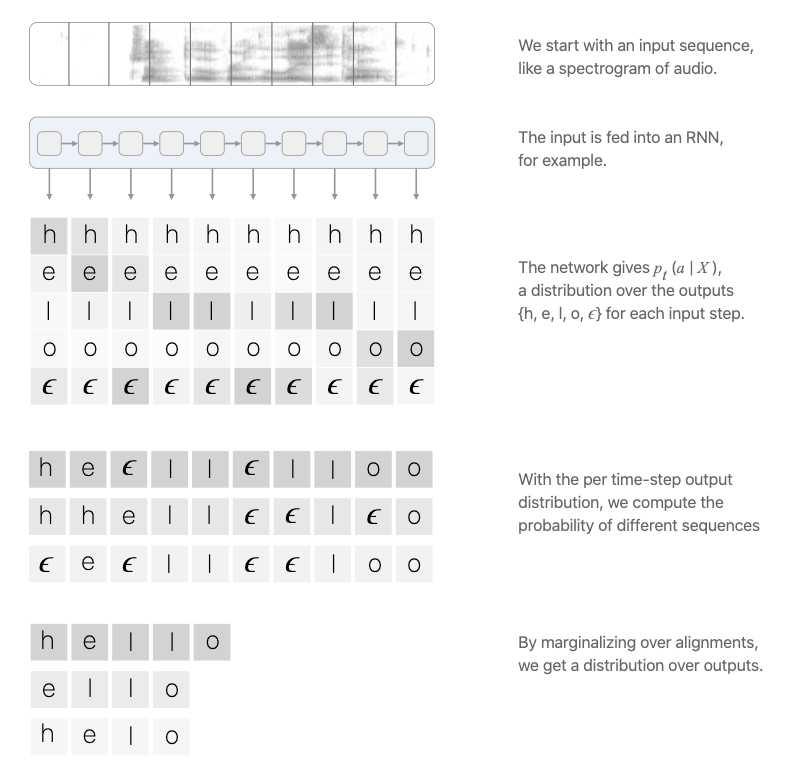

Source: https://www.assemblyai.com/blog/end-to-end-speech-recognition-pytorch/

In [ ]:
def GreedyDecoder(output, labels, label_lengths, blank_label=28, collapse_repeated=True):
    """
    Decodes the output of the model to text. Converts the model's numeric output to text using a greedy decoding approach,
    which selects the most likely token at each timestep. Collapses repeated tokens
    and skips blank labels in the output.
    """
    # find the indexes with max values
    arg_maxes = torch.argmax(output, dim=2)
    decodes = []
    targets = []
    for i, args in enumerate(arg_maxes):
        decode = []
        # convert labels to text
        targets.append(text_transform.int_to_text(labels[i][:label_lengths[i]].tolist()))
        for j, index in enumerate(args):
            # skip blank label
            if index != blank_label:
               # collapse repeated characters
                if collapse_repeated and j != 0 and index == args[j -1]:
                    continue
                decode.append(index.item())
        # convert decoded numbers to text
        decodes.append(text_transform.int_to_text(decode))
    return decodes, targets

# Train and Test

Now that we have datasets, data pipelines, and the model set up, it is time to train and test it. Both of the methods are very similar to what we have done in class. The differences are that I am using log_softmax() and not softmax() and CTC loss function and AdamW optimizer. I chose log_softmax() because softmax() resulted in higher loss value. I think the reason might be due to improved numerical performance and gradient optimization (https://datascience.stackexchange.com/questions/40714/what-is-the-advantage-of-using-log-softmax-instead-of-softmax). By the way, I choose AdamW because it helps the model converge more quickly, therefore, saving compute time. AdamW is basically Adam but with better generalization. In the test method, I am tracking average loss and average WER with the help of loss sum variable WordErrorRate() from torchevals library as mentioned in Imports section. For more details, you can read the inline comments.

In [ ]:
def train(model, device, train_loader, criterion, optimizer, epoch):
    """
    Iterates over the training dataset, does forward and backward passes,
    and updates the model parameters
    """
    # set the model to train mode due to RuntimeError: cudnn RNN backward can only be called in training mode
    model.train()
    data_len = len(train_loader.dataset)

    for batch_idx, data in enumerate(train_loader):
        spectrograms, labels, input_lengths, label_lengths = data
        spectrograms, labels = spectrograms.to(device), labels.to(device)
        optimizer.zero_grad()

        # makes sure there are no mismatches in shapes or length.
        for index in range(len(input_lengths)):
          assert input_lengths[index] >= label_lengths[index], "Input length must not be less than label length"
        assert len(input_lengths) == spectrograms.size(0), "Mismatch in batch size and input lengths"
        assert len(label_lengths) == labels.size(0), "Mismatch in batch size and label lengths"

        output = model(spectrograms)
        output = F.log_softmax(output, dim=2)
        # flipping the output. expected to be [time, batch, n_class]
        output = output.transpose(0, 1)

        loss = criterion(output, labels, input_lengths, label_lengths)
        # check for inf or nan loss
        if torch.isnan(loss) or torch.isinf(loss):
            raise ValueError("Loss is nan or inf")
        loss.backward()

        # gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        # prints out stats
        if batch_idx % 3 == 0 or batch_idx == data_len-1:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(spectrograms), data_len,
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader, criterion, epoch):
    """
    Test the output of the model using GreedyDecoder
    """
    # set the model on eval or test mode
    model.eval()
    metric = WordErrorRate().to(device)
    total_loss = 0
    with torch.no_grad():
        for I, _data in enumerate(test_loader):
            spectrograms, labels, input_lengths, label_lengths = _data
            spectrograms, labels = spectrograms.to(device), labels.to(device)

            # output is in this format (batch, time, n_class)
            output = model(spectrograms)
            # using log_softmax instead of softmax here
            output = F.log_softmax(output, dim=2)
            # flip output to (time, batch, n_class)
            output = output.transpose(0, 1)

            loss = criterion(output, labels, input_lengths, label_lengths)
            total_loss += loss.item()

            decoded_preds, decoded_targets = GreedyDecoder(output.transpose(0, 1), labels, label_lengths)
            metric.update(decoded_preds, decoded_targets)

    wer = metric.compute()
    print(f'Average Loss: {total_loss / len(test_loader)}, Word Error Rate: {wer.item()}')
    return wer.item()

# Run

In this cell, we can tune parameters and hyperparameters to try to enhance the models performance. Explain each param? Why so?
The two most important parameters here are hidden_dim and num_layers. The former is responsible for the number of units in each hidden layer of the GRU and the latter determines the "depth" of Bi-GRU layers - number of stacked layers one after another. I started out with 128 and 2 as respective values for each parameters. Given the problem of underfitting and terrible performance of the model, I decided to change up the values and increase them with each run to see if what the optimal values are. However, at the beginning, these parameters were of little value as I had a simple GRU model. After making a Bi-GRU and adding 2 Fully connected layers, my model showed a much better performance. I think there are several reasons for it. The two fully connected layers help to extract relevant features and pass them to the GRU layers. The Bi-GRU processes data in both forward and backward directions, enabling it to gather context from past and future points in the sequence, significantly improving the model's accuracy.
For my last training, I chose hidden_dim of 256, num_layers of 5, and a learning rate of 0.0001. It resulted in the best performance so far, showing the importance of more complex structe and increase number of layers to help the model extract the features and learn. The results are in the Results section.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# params for the model
num_input = 128
num_output = 29
hidden_dim = 256
# increase GRU layers is one way to improve, but adding some CNN layers or BiGRU
num_layers = 5

model = GRU(num_input, num_output, hidden_dim, num_layers).to(device)

# praparing the data loaderrs
train_loader = data.DataLoader(dataset=train_dataset, batch_size=20, shuffle=True,
                               collate_fn=lambda x: data_processing(x, 'train'))
test_loader = data.DataLoader(dataset=test_dataset, batch_size=20, shuffle=False,
                              collate_fn=lambda x: data_processing(x, 'valid'))

# setting up loss function and optimizer
criterion = nn.CTCLoss(blank=28).to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

# let's train and test the model
epochs = 10
for epoch in range(epochs):
    train(model, device, train_loader, criterion, optimizer, epoch)
    test(model, device, test_loader, criterion, epoch)

# Print Sample

Even though loss and WER are good indicators of model's relative performance, they may not show the full picture. Therefore, I, with the help of Professor Liffiton, wrote a method that prints a sample prediction made by the model after training and the target transcription of audio sample.

In [ ]:
def print_sample(model):
    """
    Prints some sample of predicted output by the model and target value using Greedy Decoder
    """
    spectrograms, labels, input_lengths, label_lengths = next(iter(train_loader))

    # extract one example from the batch
    spectrograms = spectrograms[0].unsqueeze(0)
    labels = labels[0].unsqueeze(0)
    # move tensors to the same device as model
    spectrograms, labels = spectrograms.to(device), labels.to(device)
    output = model(spectrograms)
    output = F.softmax(output, dim=2)

    # # extract the most probable predictions across all timesteps
    # output_arg = torch.argmax(output, 2)
    # transformed = text_transform.int_to_text(output_arg[0].tolist())
    # labels_new = text_transform.int_to_text(labels[0].tolist())

    decoded, targets = GreedyDecoder(output, labels, label_lengths, blank_label=28, collapse_repeated=True)
    print(decoded, targets)

print_sample(model)

# Results
The following are some of the sample predictions and targets from the print_sample() method. Ordered from the earliest to the latest


Prediction 1:

reheg and a lo hobe quit ber and making a rechtor a parn af to he posses i had behomd in the vilage this hoble however join o cotege of me and coson a parts but after mi lat dearly bot ixperin si dar not anor

Target 1:

refuge in a low hovel quite bare and making a wretched appearance after the palaces i had beheld in the village this hovel however joined a cottage of a neat and pleasant appearance but after my late dearly bought experience i dared not enter it

Prediction 2:

the wan o theba  aga o pie ro wher brepes e sero thas my her ti gra as ra ho pasin as han over he wit wa de an con fosa to a sto no ma that tos e o a hapen ye o o mi pra

Target 2:

they went to the vaults and engaged a private room where breakfast was served to them has my hair turned grey asked rehnhjelm passing his hand over his hair which was damp and clung closely to his skull no old man that doesn't often happen even i'm not grey

Prediction 3:

there were mas which haen forgers among the best nown in mos oterd in this stat and ther were thos about ca and res alart partd of these men came back afte their ser the sended to resin the pecefe live fo siticen shi

Target 3:

there were names which have been for years among the best known and most honored in this state and there were those of outcasts and wrecks a large part of these men came back after their service ended to resume the peaceful life of citizenship

**Initial Result Sample**

Prediction:

eeaaaaaaaaaaaaaaaaaaaaaaaaaaaaannnnnnnnnnnnnnnnnnnnnnnnnnnnnuuuuuuddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddd                  tthhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh<BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK>piiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiieeeeeeeeeeeeccccccrrrroooooooooooooooooooooooooooooooorruuuululsssssssssssssssss    s e<BLANK><BLANK><BLANK><BLANK>eeeeeeeeeeeeeeeeeeeeeeeetttttttttttttttttttttttttttttttttttttttttttttttttttthhhhhh<BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK>piiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiieeeeeeeeeeeeeeeeccccrrroooooooooooooooooooooooooooooooooorrruuulllsssssu<BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK>eeeeeeeeeeeeeeeeeeeeeeeeeeeeccrrrrrooooooooorrrruulllsssssssss                           ttttttttttttttttttttttttttttttttttttttttthh<BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK>eeeeeeeeeeeeeeeeeeeecrrrrrrrrrruullllssss                      eee<BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK>pppiiiiiiiieeeeeeeeeeeeeeeeeeeerrrrrrrlllllssssssssssss                    tttttttttttttttttttttttttttttttttttttttttttttttttttttthhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh<BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK><BLANK>e<BLANK><BLANK><BLANK>ppiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiizzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz

Target:

we have many truly noble statesmen in our country's service like balloon the senate is full of them don't you think so colonel well i dunno i honor my country's public servants as much as any one can i meet them sir every day and the more i see of them



The following are the graphs that show Average Loss and Average Word Error Rate for the model:

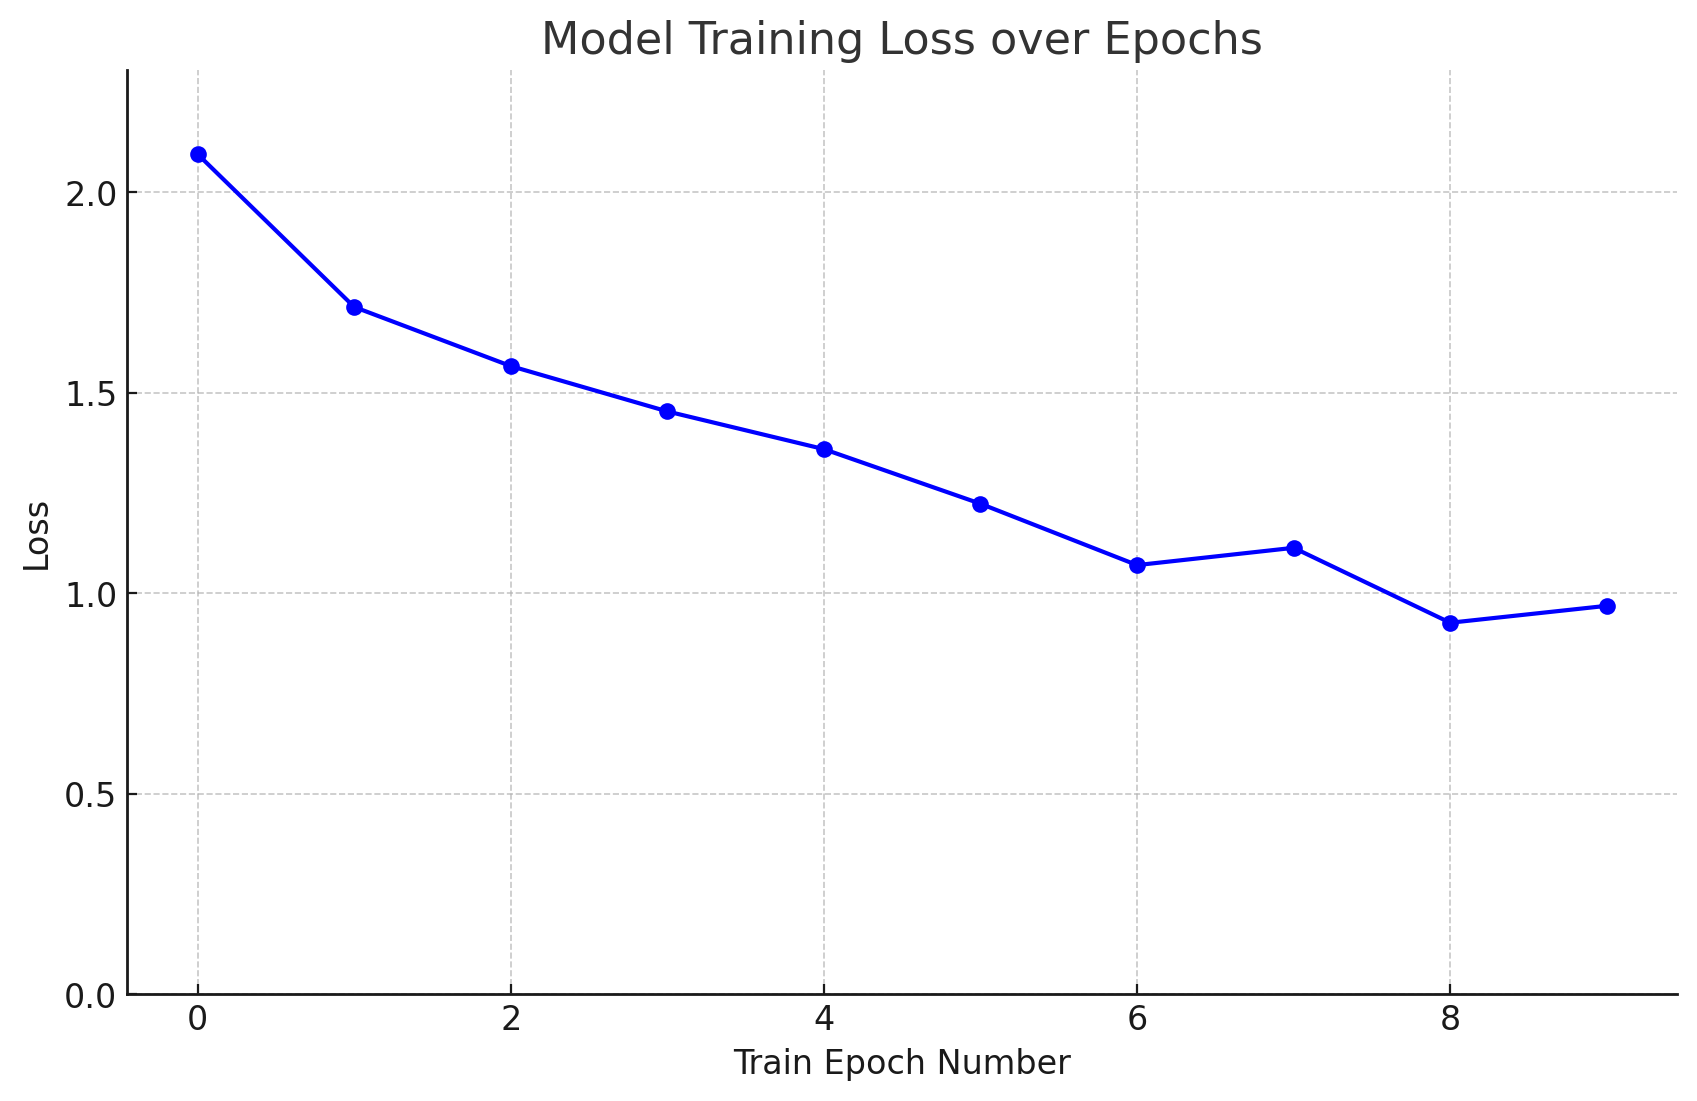

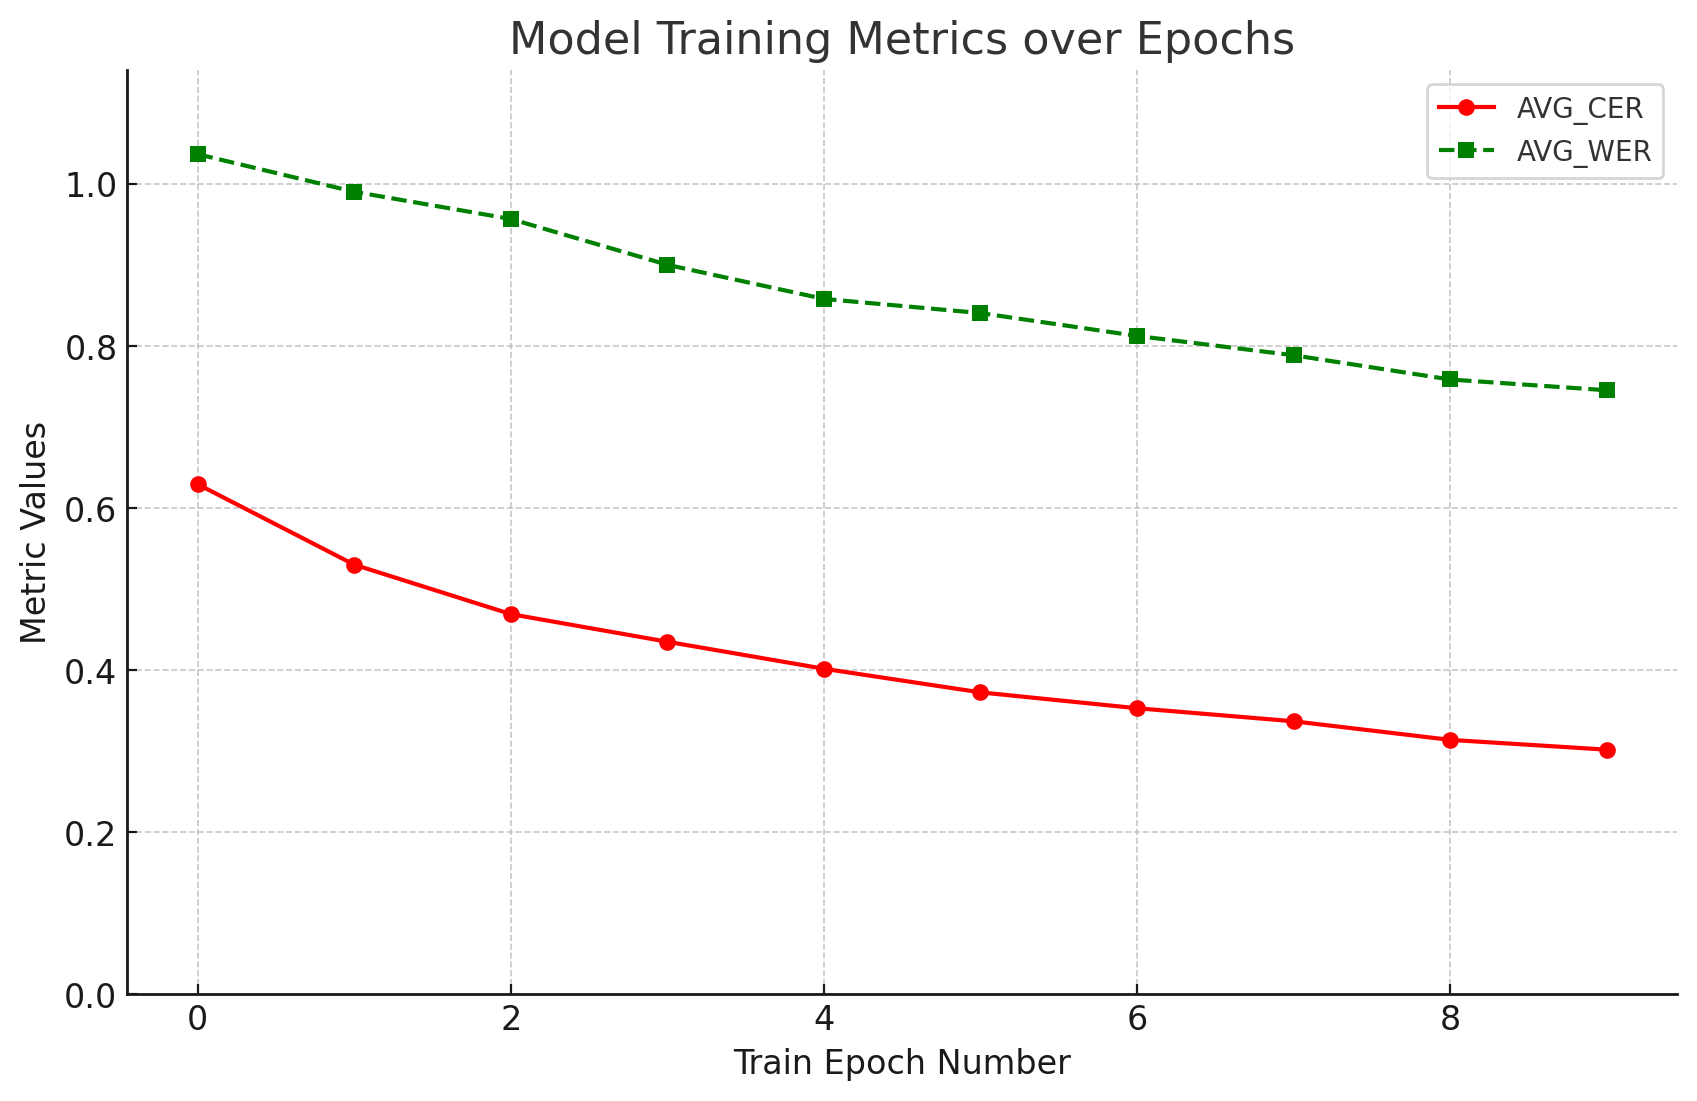

The best averages I achieved were Loss of 0.9019557656222628 and Word Error Rate of 0.6879374384880066. Although WER was very high, the model can still produce relatively intelligible transcriptions.

# Analysis
Despite falling short of proposed WER of about 20%, which is entry threshold for a good model (https://learn.microsoft.com/en-us/azure/ai-services/speech-service/how-to-custom-speech-evaluate-data?pivots=speech-studio), I am satisfied with the work I have done. Compared to the utter gibberish and loss average of 30 I was getting at the beginning, the results are a lot better. Take the third set of predictions and targets above as an example. We can clearly see the resemblance of the wrong predictions with how they sound in reality ("forgers among the best nown" vs "for years among the best known"). Nonetheless, we can observe the output often misunderstands words and omits some key words. I believe it is not solely because of simpler model architecture. Of course, a more complex and capable model with more convolutional and GRU layers could do a better job of extracting features and learning complex patters in the data. However, 100 hours of data is barely enough for anything. For example, Whisper, the model shown in class by the Professor, is trained on 680k hours of labelled data - even that does not make it 99,9% accurate. Based on the results, I can state that the model did achieve a pretty low loss values compared to initial average of 30 or even nan (I assume due to exploding gradients) and average WER decreased to about 0.68 from more than 1.1 at the beginning. I believe having Bi-GRU with 5+ layers and 512 hidden units along with the intrinsic ability to analyze the input from both past and future simultaneously played a crucial role in it. This capability is essential for capturing the full semantic and syntactic context of spoken language, which is often dependent on understanding sequences of words in their entirety rather than in isolation. The increased number of layers deepened the network's ability to learn and abstract complex patterns from the data, while the expanded number of hidden units provided a larger and more powerful neural representation to process and memorize these patterns.


# What I have learnt
This project has been very interesting and new to me despite bringing immense frustration at times. Speech Recognition is not an easy process to learn in and outs of. Evaluating the performance of the model using only WER and Loss was  challenging at first. Professor Liffiton made my life easier by showing me how to access and interpret the predictions of the model directly. This allowed me to visually inspect what the model was learning and how it was performing beyond just numerical metrics. This step was crucial for understanding the practical outcomes of the training process and for making more informed adjustments to the model.

After talking to some of my non-CS major friends, I realized that deep learning and its models seem like a black box that does magic. Therefore,I have gained a significant appreciation for the architecture of deep learning models. I learned about the advantages of using deeper models and the effectiveness of Bi-GRUs compared to standard GRUs. The bi-directional architecture, which processes data both forwards and backwards, helped immensely in capturing a more comprehensive context of the audio data and increased the transcription accuracy.

As I was experimenting with different layers, I ran into quite a few of the shape mismatch erros. They took a very long time and effort to fix due to the structure of the data which I am not used to. I think most likely cause was variance in the number of features of the input data between batches that were not correctly padded as I was messing with data_processing() method responsible for it.

Another common issue was nan loss values. This was very rare, but it did happen. I think it was caused by exploding gradients as the problem went away after using gradient clipping during training.

All in all, I have learnt a lot during this project starting from how audio is processed to many deep layers of neural networks that make learning possible.


# What now?

I cannot stop thinking that the best thing to try now is to train with more data. If the performance improves to a certain point, it would confirm my thoughts about needing more data. At that point, it is a good idea to add more complexity to the structure of the model. CNN layers can be incorporated before the GRU layers to help extract  features from spectrograms or MFCCs since they are particularly effective in capturing spatial dependencies in data, which can complement the temporal pattern recognition capabilities of GRU layers. Adding more GRU layers is another way. Adding attention mechanisms can significantly improve the model's ability to focus on relevant parts of the input sequence, potentially enhancing accuracy in longer audio sequences.

There are a few other ways to improve the performance. We can experiment with learning rate and dropout rates once we have more data to find an optimal combination. Furthermore, we could try SDG or RMSProp as out optimizer instead of AdamW. Lastly, depending if there is overfitting, we could try regularization or normalization.

However, we should also keep in mind the computational cost of enhancing the model. It would probably require a lot more resources that we can get access to.
